In [1]:
# Import libraries

# Data libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.statespace.sarimax import SARIMAX
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
import pickle

In [13]:
# Read in the data
data_path = '../../../preprocessing/data'
obs_A = pd.read_parquet(f'{data_path}/obs_A.parquet').drop(columns='date_forecast')
est_A = pd.read_parquet(f'{data_path}/est_A.parquet').drop(columns='date_forecast')
obs_B = pd.read_parquet(f'{data_path}/obs_B.parquet').drop(columns='date_forecast')
est_B = pd.read_parquet(f'{data_path}/est_B.parquet').drop(columns='date_forecast')
obs_C = pd.read_parquet(f'{data_path}/obs_C.parquet').drop(columns='date_forecast')
est_C = pd.read_parquet(f'{data_path}/est_C.parquet').drop(columns='date_forecast')

test_A = pd.read_parquet(f'{data_path}/test_A.parquet').dropna().drop(columns='date_forecast')
test_B = pd.read_parquet(f'{data_path}/test_B.parquet').dropna().drop(columns='date_forecast')
test_C = pd.read_parquet(f'{data_path}/test_C.parquet').dropna().drop(columns='date_forecast')

# Concatenate
A = pd.concat([obs_A, est_A]).drop(columns='date_calc')
B = pd.concat([obs_B, est_B]).drop(columns='date_calc')
C = pd.concat([obs_C, est_C]).drop(columns='date_calc')

# Split to features and labels
X_A = A.drop(columns=['pv_measurement'])
y_A = A['pv_measurement']
X_B = B.drop(columns=['pv_measurement'])
y_B = B['pv_measurement']
X_C = C.drop(columns=['pv_measurement'])
y_C = C['pv_measurement']

# Split into train and test
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.2, shuffle=True)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.2, shuffle=True)
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C, test_size=0.2, shuffle=True)

In [14]:
# Define models
xgb_A = XGBRegressor(n_estimators=500, learning_rate=0.001, max_depth=20, random_state=3)


In [15]:
# Fit models
xgb_A.fit(X_train_A, y_train_A, eval_set=[(X_train_A, y_train_A), (X_test_A, y_test_A)], eval_metric="mae", verbose=False)

/Users/mathiasotnes/anaconda3/envs/TDT4173-MPC/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=3, ...)

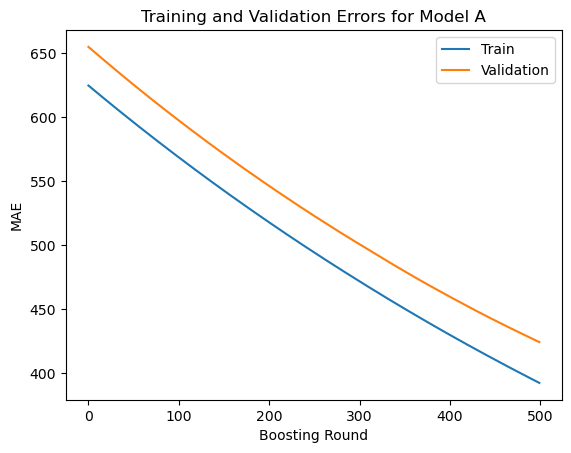

                                importance
direct_rad:W                      0.732779
diffuse_rad:W                     0.085315
sun_elevation:d                   0.020330
pressure_50m:hPa                  0.015987
precip_5min:mm                    0.012890
sun_azimuth:d                     0.011964
pressure_100m:hPa                 0.011893
month                             0.011681
dew_point_2m:K                    0.010588
precip_type_5min:idx              0.009140
sfc_pressure:hPa                  0.007475
total_cloud_cover:p               0.005459
clear_sky_rad:W                   0.004761
fresh_snow_24h:cm                 0.004742
wind_speed_u_10m:ms               0.004672
wind_speed_v_10m:ms               0.004617
clear_sky_energy_1h:J             0.003569
visibility:m                      0.003568
snow_water:kgm2                   0.003546
relative_humidity_1000hPa:p       0.003474
t_1000hPa:K                       0.003445
year                              0.002699
direct_rad_

In [16]:
# Print results
evals_results_A = xgb_A.evals_result()

train_errors = evals_results_A['validation_0']['mae']
val_errors = evals_results_A['validation_1']['mae']
plt.plot(train_errors, label='Train')
plt.plot(val_errors, label='Validation')
plt.xlabel('Boosting Round')
plt.ylabel('MAE')
plt.title('Training and Validation Errors for Model A')
plt.legend()
plt.show()

# Print feature importances
feature_importances = pd.DataFrame(xgb_A.feature_importances_,
                                   index = X_train_A.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)


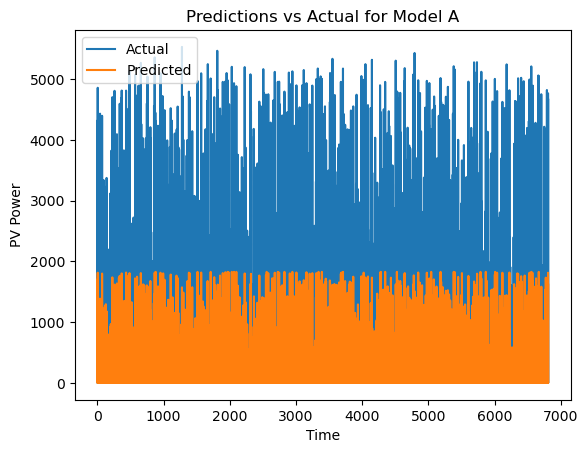

In [20]:
# Plot predictions vs actual
y_pred_A = xgb_A.predict(X_test_A)
y_pred_A = np.array(y_pred_A)
y_test_A = np.array(y_test_A)
plt.plot(y_test_A, label='Actual')
plt.plot(y_pred_A, label='Predicted')
plt.xlabel('Time')
plt.ylabel('PV Power')
plt.title('Predictions vs Actual for Model A')
plt.legend()
plt.show()

In [ ]:
# Plotting with 